In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
train.loc[:, ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea','SalePrice']]

LotArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0        8450         706           0        150          856       856   
1        9600         978           0        284         1262      1262   
2       11250         486           0        434          920       920   
3        9550         216           0        540          756       961   
4       14260         655           0        490         1145      1145   
5       14115         732           0         64          796       796   
6       10084        1369           0        317         1686      1694   
7       10382         859          32        216         1107      1107   
8        6120           0           0        952          952      1022   
9        7420         851           0        140          991      1077   
10      11200         906           0        134         1040      1040   
11      11924         998           0        177         1175      1182   
12      12968         737           0        175          912       912   
13      10652           0           0       1494         1494      1494   
14      10920         733           0        520         1253      1253   
15       6120           0           0        832          832       854   
16      11241         578           0        426         1004      1004   
17      10791           0           0          0            0      1296   
18      13695         646           0        468         1114      1114   
19       7560         504           0        525         1029      1339   
20      14215           0           0       1158         1158      1158   
21       7449           0           0        637          637      1108   
22       9742           0           0       1777         1777      1795   
23       4224         840           0        200         1040      1060   
24       8246         188         668        204         1060      1060   
25      14230           0           0       1566         1566      1600   
26       7200         234         486        180          900       900   
27      11478        1218           0        486         1704      1704   
28      16321        1277           0        207         1484      1600   
29       6324           0           0        520          520       520   
30       8500           0           0        649          649       649   
31       8544           0           0       1228         1228      1228   
32      11049           0           0       1234         1234      1234   
33      10552        1018           0        380         1398      1700   
34       7313        1153           0        408         1561      1561   
35      13418           0           0       1117         1117      1132   
36      10859           0           0       1097         1097      1097   
37       8532        1213           0         84         1297      1297   
38       7922         731           0        326         1057      1057   
39       6040           0           0          0            0      1152   
40       8658         643           0        445         1088      1324   
41      16905         967           0        383         1350      1328   
42       9180         747          93          0          840       884   
43       9200         280         491        167          938       938   
44       7945         179         506        465         1150      1150   
45       7658         456           0       1296         1752      1752   
46      12822        1351           0         83         1434      1518   
47      11096          24           0       1632         1656      1656   
48       4456           0           0        736          736       736   
49       7742         763           0        192          955       955   
50      13869         182           0        612          794       794   
51       6240           0           0        816          816       816   
52       8472         104      

In [6]:
train_skew = train[train.columns[train.dtypes!=object]].skew()

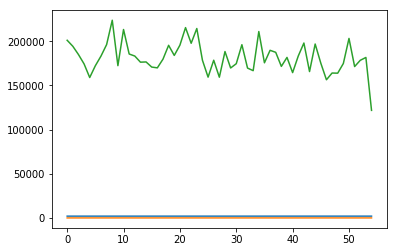

In [7]:
plt.plot(train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean())

In [8]:
train[train['SalePrice']>700000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691    692          60       RL        104.0    21535   Pave   NaN      IR1   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
691          Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
1182         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
691        Norm     1Fam     2Story           10            6       1994   
1182       Norm     1Fam     2Story           10            5       1996   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
691           1995     Gable  WdShngl     HdBoard     HdBoard    BrkFace   
1182          1996       Hip  CompShg     Wd Sdng     ImStucc       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
691       1170.0        Ex        TA      PConc       Ex       TA   
1182         0.0        Gd        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
691            Gd          GLQ        1455          Unf           0   
1182           Av          GLQ        2096          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
691         989         2444    GasA        Ex          Y      SBrkr   
1182        300         2396    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
691       2444      1872             0       4316             0             1   
1182      2411      2065             0       4476             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
691          3         1             4             1          Ex   
1182         3         1             4             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
691             10        Typ           2          Ex     Attchd       1994.0   
1182            10        Typ           2          TA     Attchd       1996.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
691           Fin           3         832         TA         TA          Y   
1182          Fin           3         813         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
691          382           50              0          0            0   
1182         171           78              0          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
691          0    NaN    NaN         NaN        0       1    2007       WD   
1182       555     Ex  MnPrv         NaN        0       7    2007       WD   

     SaleCondition  SalePrice  
691         Normal     755000  
1182       Abnorml     745000

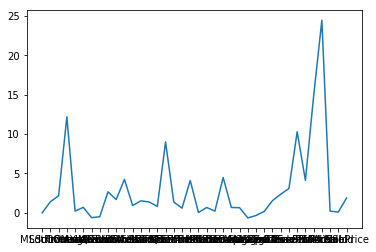

In [9]:
plt.plot(train_skew)

In [10]:
skewed_columns = train_skew.index[train_skew.abs()>1.5]

In [11]:
y_train = train['SalePrice'].values

In [12]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [13]:
test_id = test['Id'].values

In [14]:
del train['Id'], test['Id']

In [15]:
all_data = pd.concat([train, test], axis=0)

In [16]:
all_data.shape

(2919, 79)

In [17]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>1.5]

In [18]:
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [19]:
stats.skew(np.log(y_train))

0.1212103673013655

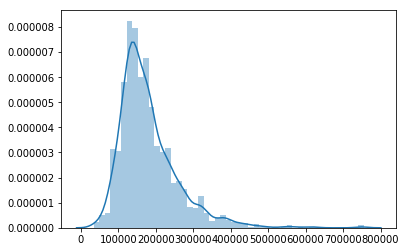

In [20]:
sns.distplot(y_train)

In [21]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF2          1
BsmtFinSF1          1
Exterior2nd         1
BsmtUnfSF           1
TotalBsmtSF         1
Exterior1st         1
SaleType            1
Electrical          1
KitchenQual         1
GarageArea          1
GarageCars          1
OverallQual         0
OverallCond         0
LotArea             0
Street              0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType  

In [22]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF2        1  0.000343
BsmtFinSF1        1  0.000343
Exterior2nd       1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
Exterior1st       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea        1  0.000343
GarageCars        1  0.000343
OverallQual       0  0.000000
OverallCond       0  0.000000
LotArea           0  0.000000
Street            0  0.000000
LotShape          0  0.000000
LandContour       0  0.000000

In [23]:
all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

In [24]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [25]:
all_data['Neighborhood+Exterior1st'] = all_data['Neighborhood'] + '+'+ all_data['Exterior1st']
all_data['MSZoning+CentralAir'] = all_data['MSZoning'] + '+'+ all_data['CentralAir']
all_data['OverallCond+BsmtExposure'] = all_data['OverallCond'] + '+'+ all_data['BsmtExposure']
all_data['Foundation+SaleCondition'] = all_data['Foundation'] + '+'+ all_data['SaleCondition']
all_data['Neighborhood+BsmtExposure'] = all_data['Neighborhood'] + '+'+ all_data['BsmtExposure']
all_data['Neighborhood+GarageFinish'] = all_data['Neighborhood'] + '+'+ all_data['GarageFinish']
all_data['Neighborhood+SaleCondition'] = all_data['Neighborhood'] + '+'+ all_data['SaleCondition']
all_data['Neighborhood+OverallCond'] = all_data['Neighborhood'] + '+'+ all_data['OverallCond']
all_data['KitchenQual+SaleCondition'] = all_data['KitchenQual'] + '+'+ all_data['SaleCondition']
all_data['Exterior1st+BsmtFinType1'] = all_data['Exterior1st'] + '+'+ all_data['BsmtFinType1']

In [26]:
all_data['MSZoning+OverallQual'] = all_data['MSZoning'] + '+'+ all_data['OverallQual']
all_data['FireplaceQu+GarageType'] = all_data['FireplaceQu'] + '+'+ all_data['GarageType']
all_data['OverallQual+PavedDrive'] = all_data['OverallQual'] + '+'+ all_data['PavedDrive']
all_data['OverallQual+CentralAir'] = all_data['OverallQual'] + '+'+ all_data['CentralAir']
all_data['RoofStyle+KitchenQual'] = all_data['RoofStyle'] + '+'+ all_data['KitchenQual']
all_data['KitchenQual+FireplaceQu'] = all_data['KitchenQual'] + '+'+ all_data['FireplaceQu']
all_data['BsmtExposure+KitchenQual'] = all_data['BsmtExposure'] + '+'+ all_data['KitchenQual']
all_data['BldgType+OverallQual'] = all_data['BldgType'] + '+'+ all_data['OverallQual']

In [27]:
all_data.shape

(2919, 97)

#all_data['OverallQual+Cond'] =(all_data['OverallQual']).astype(str) + (all_data['OverallCond']).astype(str)
#all_data['OverallQual*Cond'] =(all_data['OverallQual'] * all_data['OverallCond']).astype(str)


all_data['Neigh_Zone']  = all_data['Neighborhood'].astype(str) +'_'+ all_data['MSZoning'].astype(str)
all_data['SaleType_Condition']  = all_data['SaleType'].astype(str) +'_'+ all_data['SaleCondition'].astype(str)

In [28]:
col_obj = all_data.columns[all_data.dtypes==object]
col_obj

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition',
       'Neighborhood+Exterior1st', 'MSZoning+CentralAir',
       'OverallCond+BsmtExposure', 'Foundation+SaleCondition',
       'Neighborhood+BsmtExposure', 'Neighborhood+GarageFinish',
       'Neighborhood+SaleCondition', 'Neighborhood+OverallCond',
       'KitchenQual+SaleCondition', 'Exterior1st+BsmtFinType1',

In [29]:
col_num = all_data.columns[all_data.dtypes!=object]
col_num

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

all_data['TotalBsmt_0'] = (all_data['TotalBsmtSF']==0).astype(int)
all_data['1st-TotalBsmtSF'] = all_data['1stFlrSF'] - all_data['TotalBsmtSF']
all_data['2ndFlr_Flag'] = (all_data['2ndFlrSF']!=0).astype(int)
all_data['BsmtUnfRate'] = all_data['BsmtUnfSF']/all_data['1stFlrSF']
all_data['LowQualRate'] = all_data['LowQualFinSF']/all_data['GrLivArea']
all_data['1st/Lot']     = all_data['1stFlrSF']/all_data['LotArea']
all_data['1st+2ndSF']   = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['2nd/1st']     = all_data['2ndFlrSF'] / all_data['1stFlrSF']
all_data['YearRemo-Gar'] = all_data['YearRemodAdd'] - all_data['GarageYrBlt']
all_data['1st+2nd+GarSF']= all_data['1st+2ndSF'] + all_data['GarageArea']
all_data['1st+2nd+Gar/Lot'] = all_data['1st+2nd+GarSF'] / all_data['LotArea']

In [30]:
for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [31]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

Total   Percent
LotFrontage             486  0.166495
GarageYrBlt             159  0.054471
MasVnrArea               23  0.007879
BsmtFullBath              2  0.000685
BsmtHalfBath              2  0.000685
TotalBsmtSF               1  0.000343
BsmtFinSF1                1  0.000343
GarageArea                1  0.000343
GarageCars                1  0.000343
BsmtUnfSF                 1  0.000343
BsmtFinSF2                1  0.000343
Heating                   0  0.000000
HeatingQC                 0  0.000000
CentralAir                0  0.000000
Electrical                0  0.000000
BsmtFinType2              0  0.000000
1stFlrSF                  0  0.000000
2ndFlrSF                  0  0.000000
LowQualFinSF              0  0.000000
BsmtFinType1              0  0.000000
BsmtExposure              0  0.000000
BsmtCond                  0  0.000000
BsmtQual                  0  0.000000
Foundation                0  0.000000
ExterCond                 0  0.000000
ExterQual                 0  0.000000
BldgType+OverallQual      0  0.000000
GrLivArea                 0  0.000000
Exterior2nd               0  0.000000
MSZoning                  0  0.000000
LotArea                   0  0.000000
Street                    0  0.000000
Alley                     0  0.000000
LotShape                  0  0.000000
LandContour               0  0.000000
Utilities                 0  0.000000
LotConfig                 0  0.000000
LandSlope                 0  0.000000
Neighborhood              0  0.000000
Condition1                0  0.000000

In [32]:
all_data['LotFrontage'].mean()

69.30579531442663

In [33]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

In [34]:
all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median()

201.0

In [35]:
all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

In [36]:
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

In [37]:
all_data.fillna(all_data.mean(), inplace=True)

all_data['YearBuilt/YrSold'] = all_data['YearBuilt']/(all_data['YrSold']+1)
#all_data['GrLivArea/BedroomAbvGr'] = all_data['GrLivArea']/(all_data['BedroomAbvGr']+1)
all_data['YearRemodAdd/YrSold'] = all_data['YearRemodAdd']/(all_data['YrSold']+1)
#all_data['TotalBsmtSF/KitchenAbvGr'] = all_data['TotalBsmtSF']/(all_data['KitchenAbvGr']+1)
#all_data['LotArea/LotFrontage'] = all_data['LotArea']/(all_data['LotFrontage']+1)
#all_data['LotArea/MiscVal'] = all_data['LotArea']/(all_data['MiscVal']+1)

#all_data['GrLivArea/KitchenAbvGr'] = all_data['GrLivArea']/(all_data['KitchenAbvGr']+1)
#all_data['GarageCars/KitchenAbvGr'] = all_data['GarageCars']/(all_data['KitchenAbvGr']+1)
#all_data['KitchenAbvGr/GarageCars'] = all_data['KitchenAbvGr']/(all_data['GarageCars']+1)
#all_data['GrLivArea/LowQualFinSF'] = all_data['GrLivArea']/(all_data['LowQualFinSF']+1)
#all_data['GarageArea/MiscVal'] = all_data['GarageArea']/(all_data['MiscVal']+1)

In [ ]:
for i in range(len(col_num)):
    for j in range(len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'/'+str(col_num[j])] = all_data[col_num[i]]/(all_data[col_num[j]]+1)

all_data['TotalBsmtSF+GrLivArea'] = all_data['TotalBsmtSF'] + all_data['GrLivArea']

In [ ]:
for i in range(len(col_num)):
    for j in range(i, len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'+'+str(col_num[j])] = all_data[col_num[i]] + all_data[col_num[j]]

In [ ]:
for i in range(len(col_num)):
    for j in range(i, len(col_num)):
        if i!=j:            
            all_data[str(col_num[i])+'-'+str(col_num[j])] = all_data[col_num[i]] - all_data[col_num[j]]

In [42]:
all_data.skew()

MSSubClass                     1.140549
MSZoning                       2.656140
LotFrontage                    1.675713
LotArea                       12.829025
Street                        15.508104
Alley                          4.140513
LotShape                       1.262181
LandContour                    3.407074
Utilities                    -10.372700
LotConfig                      1.382671
LandSlope                      4.977715
Neighborhood                   0.192788
Condition1                     3.737025
Condition2                    12.239955
BldgType                       2.165183
HouseStyle                     2.007841
OverallQual                    0.839296
OverallCond                    1.455416
YearBuilt                     -0.600114
YearRemodAdd                  -0.451252
RoofStyle                      3.647237
RoofMatl                       9.382127
Exterior1st                    1.206716
Exterior2nd                    1.054638
MasVnrType                     0.229984


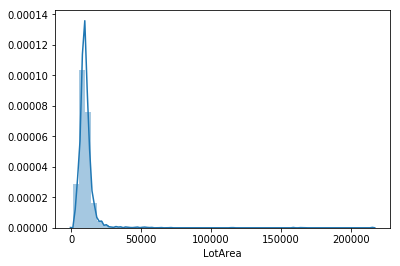

In [43]:
sns.distplot((all_data['LotArea']))

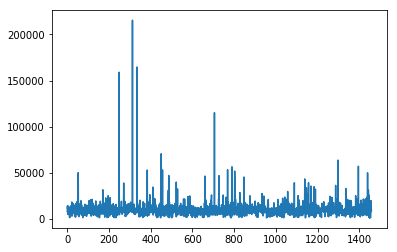

In [44]:
plt.plot((all_data['LotArea']))

In [45]:
all_data['LotArea'].mean()

10168.11408016444

In [46]:
#np.percentile(all_data['LotArea'], 95)

In [47]:
#all_data['LotArea'] = np.clip(all_data['LotArea'], a_min=all_data['LotArea'].min(), a_max=np.percentile(all_data['LotArea'], 95))

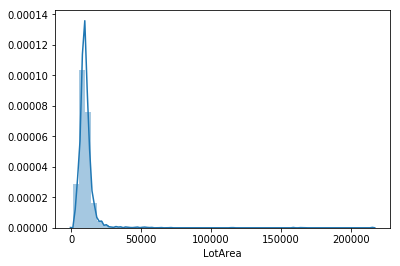

In [48]:
sns.distplot((all_data['LotArea']))

In [49]:
all_data.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0           0         0         65.0     8450       0     -1         0   
1           1         0         80.0     9600       0     -1         0   
2           0         0         68.0    11250       0     -1         1   
3           2         0         60.0     9550       0     -1         1   
4           0         0         84.0    14260       0     -1         1   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
0            0          0          0          0             0           0   
1            0          0          1          0             1           1   
2            0          0          0          0             0           0   
3            0          0          2          0             2           0   
4            0          0          1          0             3           0   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0           0         0           0            0            0       2003   
1           0         0           1            1            1       1976   
2           0         0           0            0            0       2001   
3           0         0           0            0            0       1915   
4           0         0           0            2            0       2000   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0          2003          0         0            0            0           0   
1          1976          0         0            1            1           1   
2          2002          0         0            0            0           0   
3          1970          0         0            2            2           1   
4          2000          0         0            0            0           0   

   MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
0       196.0          0          0           0         0         0   
1         0.0          1          0           1         0         0   
2       162.0          0          0           0         0         0   
3         0.0          1          0           2         1         1   
4       350.0          0          0           0         0         0   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0             0             0       706.0             0         0.0   
1             1             1       978.0             0         0.0   
2             2             0       486.0             0         0.0   
3             0             1       216.0             0         0.0   
4             3             0       655.0             0         0.0   

   BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  Electrical  \
0      150.0        856.0        0          0           0           0   
1      284.0       1262.0        0          0           0           0   
2      434.0        920.0        0          0           0           0   
3      540.0        756.0        0          1           0           0   
4      490.0       1145.0        0          0           0           0   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710           1.0           0.0   
1      1262         0             0       1262           0.0           1.0   
2       920       866             0       1786           1.0           0.0   
3       961       756             0       1717           1.0           0.0   
4      1145      1053             0       2198           1.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0         2         1             3             1            0             8   
1         2         0             3             1            1             6   
2         2         1             3             1            0             6   
3         1         0             3             1            0             7   
4      

In [50]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [51]:
y_train_log = np.log(y_train)

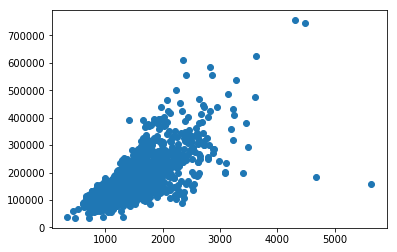

In [52]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [53]:
train[train['GrLivArea']>4000]['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

In [54]:
train = pd.concat([train, pd.DataFrame({'SalePrice':y_train})], axis=1)

In [55]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [56]:
train.shape

(1458, 101)

In [57]:
def mean_encoding(train, test, cols):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    skf = skf.split(train, train['SalePrice'])
    for col in cols:
        train[col+'_mean_encoding'] = 0
        test[col+'_mean_encoding'] = test[col].map(train.groupby(col)['SalePrice'].mean())
    for tr_idx,val_idx in skf:
        X_tr, X_val = train.iloc[tr_idx, :], train.iloc[val_idx, :]
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col)['SalePrice'].mean())
            train[col+'_mean_encoding'].iloc[val_idx] = means
    prior = train['SalePrice'].mean()
    train.fillna(prior, inplace=True)
    test.fillna(prior, inplace=True)
    return train,test

In [58]:
#train, test = mean_encoding(train, test, col_obj)

In [59]:
train.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0           0         0         65.0     8450       0     -1         0   
1           1         0         80.0     9600       0     -1         0   
2           0         0         68.0    11250       0     -1         1   
3           2         0         60.0     9550       0     -1         1   
4           0         0         84.0    14260       0     -1         1   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
0            0          0          0          0             0           0   
1            0          0          1          0             1           1   
2            0          0          0          0             0           0   
3            0          0          2          0             2           0   
4            0          0          1          0             3           0   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0           0         0           0            0            0       2003   
1           0         0           1            1            1       1976   
2           0         0           0            0            0       2001   
3           0         0           0            0            0       1915   
4           0         0           0            2            0       2000   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0          2003          0         0            0            0           0   
1          1976          0         0            1            1           1   
2          2002          0         0            0            0           0   
3          1970          0         0            2            2           1   
4          2000          0         0            0            0           0   

   MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
0       196.0          0          0           0         0         0   
1         0.0          1          0           1         0         0   
2       162.0          0          0           0         0         0   
3         0.0          1          0           2         1         1   
4       350.0          0          0           0         0         0   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0             0             0       706.0             0         0.0   
1             1             1       978.0             0         0.0   
2             2             0       486.0             0         0.0   
3             0             1       216.0             0         0.0   
4             3             0       655.0             0         0.0   

   BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  Electrical  \
0      150.0        856.0        0          0           0           0   
1      284.0       1262.0        0          0           0           0   
2      434.0        920.0        0          0           0           0   
3      540.0        756.0        0          1           0           0   
4      490.0       1145.0        0          0           0           0   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710           1.0           0.0   
1      1262         0             0       1262           0.0           1.0   
2       920       866             0       1786           1.0           0.0   
3       961       756             0       1717           1.0           0.0   
4      1145      1053             0       2198           1.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0         2         1             3             1            0             8   
1         2         0             3             1            1             6   
2         2         1             3             1            0             6   
3         1         0             3             1            0             7   
4      

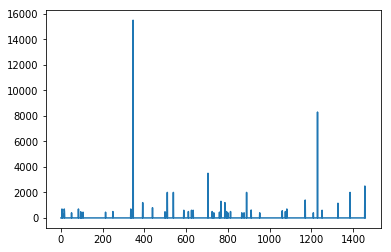

In [60]:
plt.plot(train['MiscVal'])

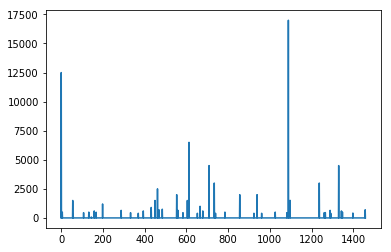

In [61]:
plt.plot(test['MiscVal'])

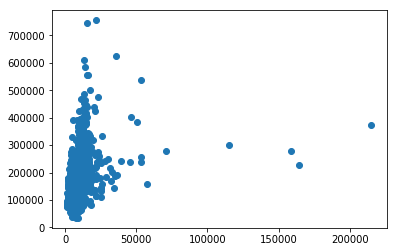

In [62]:
plt.scatter(x=train['LotArea'], y=train['SalePrice'])

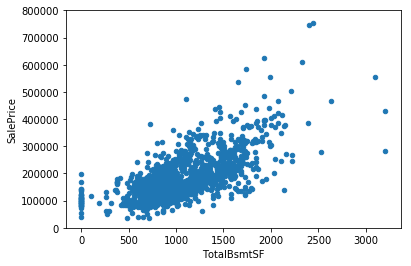

In [63]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

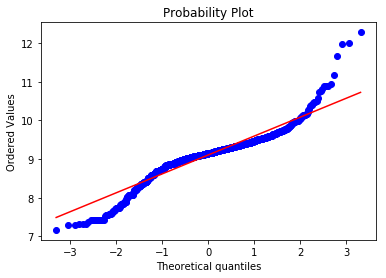

In [64]:
res = stats.probplot(np.log(train['LotArea']), plot=plt)

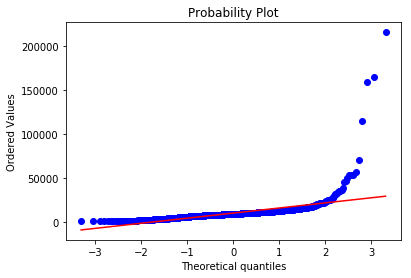

In [65]:
res = stats.probplot(train['LotArea'], plot=plt)

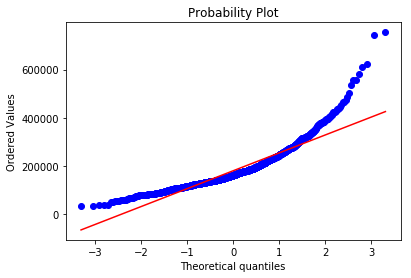

In [66]:
res = stats.probplot(train['SalePrice'], plot=plt)

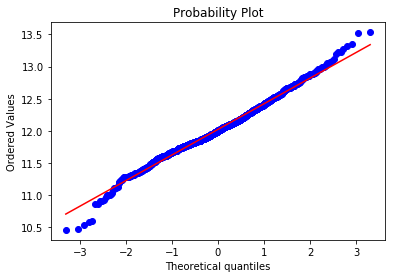

In [67]:
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

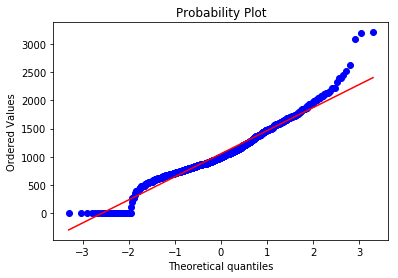

In [68]:
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

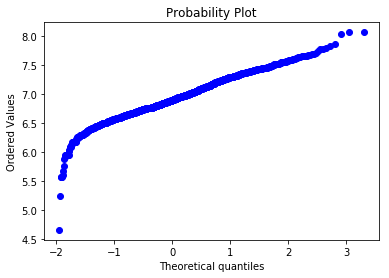

In [69]:
res = stats.probplot(np.log(train['TotalBsmtSF']), plot=plt)

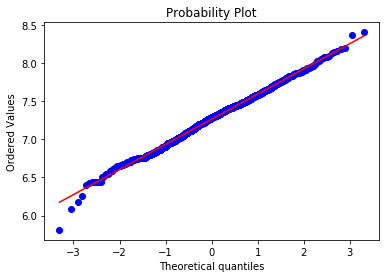

In [70]:
res = stats.probplot(np.log(train['GrLivArea']), plot=plt)

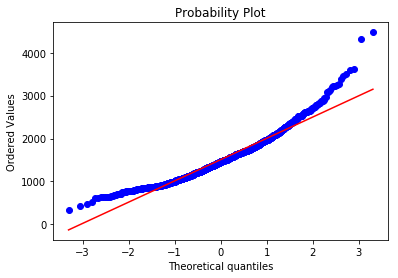

In [71]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [72]:
sf_cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [73]:
cols = ['TotalBsmtSF', 'LotArea']

for df in [train, test]:
    #df['GrLivArea_log'] = np.log(df['GrLivArea'])        
    #df['YrRem-Bui'] = df['YearRemodAdd'] - df['YearBuilt']
    for col in sf_cols:
        df[col+'_sqrt'] = np.sqrt(df[col]) 
        df[col+'_log'] = np.zeros(df.shape[0])
        df[col+'_log'].loc[df[df[col]>0].index] = np.log(df[col])

In [74]:
y_train = train['SalePrice'].values
del train['SalePrice']

In [75]:
all_data = pd.concat([train, test], axis=0)
#ob_col = all_data.columns[all_data.dtypes==object]

In [76]:
#all_data.fillna('NA', inplace=True)
#all_data[col_obj] = all_data[col_obj].astype(str)
#all_data = pd.get_dummies(all_data)

In [77]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [78]:
train.shape

(1458, 100)

In [79]:
y_train_log = np.log(y_train)

In [80]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=123)

In [81]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.linear_model import LinearRegression, Lasso

reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

coef = pd.Series(model_lasso.coef_, index = train.columns)

coef

dropf = coef.loc[coef==0].index
print(dropf)

0.13607179302057143
Index(['YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'BsmtExposure',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'Electrical', '2ndFlrSF',
       'BsmtHalfBath', 'GarageType', '3SsnPorch', 'PoolQC', 'MoSold',
       'SaleCondition', 'Neighborhood+BsmtExposure', 'MSZoning+OverallQual'],
      dtype='object')


In [82]:
0.12075221409291992

0.12075221409291992

In [83]:
#train = train.drop(dropf, axis=1)

In [84]:
coef.sort_values(ascending=False)

TotalBsmtSF+GrLivArea         0.100813
GrLivArea                     0.083271
YearRemodAdd/YrSold           0.057574
MSZoning+CentralAir           0.056891
YearBuilt/YrSold              0.044619
BsmtFinSF1                    0.027615
FullBath                      0.027532
GarageCars                    0.023273
FireplaceQu                   0.019073
GarageArea                    0.018407
OverallCond+BsmtExposure      0.017174
ScreenPorch                   0.016131
LotArea                       0.015418
TotRmsAbvGrd                  0.015374
RoofStyle+KitchenQual         0.013538
HalfBath                      0.013057
Fireplaces                    0.012838
LotFrontage                   0.012575
HouseStyle                    0.012163
OverallQual+CentralAir        0.012123
Neighborhood+Exterior1st      0.011512
BsmtQual                      0.010930
BldgType                      0.009173
BsmtFullBath                  0.009007
WoodDeckSF                    0.008918
LandContour              

In [85]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 3,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [86]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.359702
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.334642
[3]	valid_0's rmse: 0.312394
[4]	valid_0's rmse: 0.290863
[5]	valid_0's rmse: 0.272991
[6]	valid_0's rmse: 0.256062
[7]	valid_0's rmse: 0.242991
[8]	valid_0's rmse: 0.229356
[9]	valid_0's rmse: 0.217127
[10]	valid_0's rmse: 0.208016
[11]	valid_0's rmse: 0.198791
[12]	valid_0's rmse: 0.191033
[13]	valid_0's rmse: 0.184452
[14]	valid_0's rmse: 0.178991
[15]	valid_0's rmse: 0.173446
[16]	valid_0's rmse: 0.169063
[17]	valid_0's rmse: 0.164161
[18]	valid_0's rmse: 0.160735
[19]	valid_0's rmse: 0.157372
[20]	valid_0's rmse: 0.15484
[21]	valid_0's rmse: 0.152651
[22]	valid_0's rmse: 0.150808
[23]	valid_0's rmse: 0.149159
[24]	valid_0's rmse: 0.147095
[25]	valid_0's rmse: 0.145579
[26]	valid_0's rmse: 0.143817
[27]	valid_0's rmse: 0.142913
[28]	valid_0's rmse: 0.141935
[29]	valid_0's rmse: 0.140507
[30]	valid_0's rmse: 0.139445
[31]	valid_0's rmse: 0.138082
[32]	valid_0's rm

[416]	valid_0's rmse: 0.115473
[417]	valid_0's rmse: 0.115506
[418]	valid_0's rmse: 0.115339
[419]	valid_0's rmse: 0.115308
[420]	valid_0's rmse: 0.115303
[421]	valid_0's rmse: 0.115314
[422]	valid_0's rmse: 0.115317
[423]	valid_0's rmse: 0.11541
[424]	valid_0's rmse: 0.115385
[425]	valid_0's rmse: 0.115388
[426]	valid_0's rmse: 0.115436
[427]	valid_0's rmse: 0.115381
[428]	valid_0's rmse: 0.115509
[429]	valid_0's rmse: 0.115536
[430]	valid_0's rmse: 0.115548
[431]	valid_0's rmse: 0.115544
[432]	valid_0's rmse: 0.115559
[433]	valid_0's rmse: 0.115589
[434]	valid_0's rmse: 0.115614
[435]	valid_0's rmse: 0.115633
[436]	valid_0's rmse: 0.115608
[437]	valid_0's rmse: 0.115626
[438]	valid_0's rmse: 0.115575
[439]	valid_0's rmse: 0.115615
[440]	valid_0's rmse: 0.115607
Early stopping, best iteration is:
[340]	valid_0's rmse: 0.115213
[1]	valid_0's rmse: 0.397467
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.369471
[3]	valid_0's rmse: 0.343052
[4]	valid_

[248]	valid_0's rmse: 0.127734
[249]	valid_0's rmse: 0.127656
[250]	valid_0's rmse: 0.127603
[251]	valid_0's rmse: 0.127641
[252]	valid_0's rmse: 0.127543
[253]	valid_0's rmse: 0.127532
[254]	valid_0's rmse: 0.127426
[255]	valid_0's rmse: 0.127408
[256]	valid_0's rmse: 0.127368
[257]	valid_0's rmse: 0.127354
[258]	valid_0's rmse: 0.127376
[259]	valid_0's rmse: 0.127316
[260]	valid_0's rmse: 0.127355
[261]	valid_0's rmse: 0.127296
[262]	valid_0's rmse: 0.127268
[263]	valid_0's rmse: 0.12731
[264]	valid_0's rmse: 0.127252
[265]	valid_0's rmse: 0.127205
[266]	valid_0's rmse: 0.127189
[267]	valid_0's rmse: 0.127211
[268]	valid_0's rmse: 0.127199
[269]	valid_0's rmse: 0.127229
[270]	valid_0's rmse: 0.127181
[271]	valid_0's rmse: 0.127137
[272]	valid_0's rmse: 0.127097
[273]	valid_0's rmse: 0.127142
[274]	valid_0's rmse: 0.127065
[275]	valid_0's rmse: 0.127089
[276]	valid_0's rmse: 0.127127
[277]	valid_0's rmse: 0.127097
[278]	valid_0's rmse: 0.127004
[279]	valid_0's rmse: 0.127019
[280]	val

[21]	valid_0's rmse: 0.168588
[22]	valid_0's rmse: 0.164793
[23]	valid_0's rmse: 0.162238
[24]	valid_0's rmse: 0.159565
[25]	valid_0's rmse: 0.157466
[26]	valid_0's rmse: 0.155983
[27]	valid_0's rmse: 0.154433
[28]	valid_0's rmse: 0.153103
[29]	valid_0's rmse: 0.151959
[30]	valid_0's rmse: 0.150463
[31]	valid_0's rmse: 0.149405
[32]	valid_0's rmse: 0.148689
[33]	valid_0's rmse: 0.147885
[34]	valid_0's rmse: 0.1475
[35]	valid_0's rmse: 0.146869
[36]	valid_0's rmse: 0.146433
[37]	valid_0's rmse: 0.145922
[38]	valid_0's rmse: 0.145475
[39]	valid_0's rmse: 0.144679
[40]	valid_0's rmse: 0.144242
[41]	valid_0's rmse: 0.143756
[42]	valid_0's rmse: 0.143058
[43]	valid_0's rmse: 0.142808
[44]	valid_0's rmse: 0.142474
[45]	valid_0's rmse: 0.142086
[46]	valid_0's rmse: 0.141581
[47]	valid_0's rmse: 0.141014
[48]	valid_0's rmse: 0.140559
[49]	valid_0's rmse: 0.14035
[50]	valid_0's rmse: 0.14012
[51]	valid_0's rmse: 0.139849
[52]	valid_0's rmse: 0.139631
[53]	valid_0's rmse: 0.13928
[54]	valid_0's 

[217]	valid_0's rmse: 0.116773
[218]	valid_0's rmse: 0.116798
[219]	valid_0's rmse: 0.116782
[220]	valid_0's rmse: 0.116789
[221]	valid_0's rmse: 0.116798
[222]	valid_0's rmse: 0.11686
[223]	valid_0's rmse: 0.116864
[224]	valid_0's rmse: 0.11693
[225]	valid_0's rmse: 0.116981
[226]	valid_0's rmse: 0.117041
[227]	valid_0's rmse: 0.116879
[228]	valid_0's rmse: 0.116891
[229]	valid_0's rmse: 0.116817
[230]	valid_0's rmse: 0.11677
[231]	valid_0's rmse: 0.116689
[232]	valid_0's rmse: 0.116682
[233]	valid_0's rmse: 0.116629
[234]	valid_0's rmse: 0.116598
[235]	valid_0's rmse: 0.116487
[236]	valid_0's rmse: 0.116459
[237]	valid_0's rmse: 0.116519
[238]	valid_0's rmse: 0.116401
[239]	valid_0's rmse: 0.116377
[240]	valid_0's rmse: 0.116175
[241]	valid_0's rmse: 0.11617
[242]	valid_0's rmse: 0.116066
[243]	valid_0's rmse: 0.115985
[244]	valid_0's rmse: 0.116015
[245]	valid_0's rmse: 0.116001
[246]	valid_0's rmse: 0.115866
[247]	valid_0's rmse: 0.115914
[248]	valid_0's rmse: 0.115878
[249]	valid_

[333]	valid_0's rmse: 0.121992
[334]	valid_0's rmse: 0.121979
[335]	valid_0's rmse: 0.121955
[336]	valid_0's rmse: 0.121977
[337]	valid_0's rmse: 0.121991
[338]	valid_0's rmse: 0.121978
[339]	valid_0's rmse: 0.121965
[340]	valid_0's rmse: 0.121945
[341]	valid_0's rmse: 0.121956
[342]	valid_0's rmse: 0.121976
[343]	valid_0's rmse: 0.121998
[344]	valid_0's rmse: 0.122044
[345]	valid_0's rmse: 0.122056
[346]	valid_0's rmse: 0.122121
[347]	valid_0's rmse: 0.122074
[348]	valid_0's rmse: 0.122071
[349]	valid_0's rmse: 0.122143
[350]	valid_0's rmse: 0.122101
[351]	valid_0's rmse: 0.122129
[352]	valid_0's rmse: 0.122119
[353]	valid_0's rmse: 0.122206
[354]	valid_0's rmse: 0.122332
[355]	valid_0's rmse: 0.122269
[356]	valid_0's rmse: 0.122193
[357]	valid_0's rmse: 0.122169
[358]	valid_0's rmse: 0.122251
[359]	valid_0's rmse: 0.122316
[360]	valid_0's rmse: 0.122226
[361]	valid_0's rmse: 0.122208
[362]	valid_0's rmse: 0.122174
[363]	valid_0's rmse: 0.122196
[364]	valid_0's rmse: 0.122249
[365]	va

In [87]:
np.sum(val_rmse)/n_folds

0.1217319774354018

In [88]:
0.1217319774354018

0.12312769839085329

In [89]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [90]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

Importance
TotalBsmtSF+GrLivArea             88.2
LotArea                           86.2
GrLivArea                         68.8
GarageArea                        63.2
BsmtUnfSF                         56.0
BsmtFinSF1                        55.2
YearBuilt/YrSold                  51.8
GarageYrBlt                       50.2
1stFlrSF                          48.8
Neighborhood+OverallCond          44.8
TotalBsmtSF                       43.6
YearRemodAdd/YrSold               43.2
Neighborhood+SaleCondition        42.2
Neighborhood+Exterior1st          41.8
LotFrontage                       40.0
OverallCond+BsmtExposure          39.8
Neighborhood+GarageFinish         38.2
Neighborhood+BsmtExposure         37.4
OpenPorchSF                       35.8
OverallCond                       35.8
Exterior1st+BsmtFinType1          32.2
KitchenQual+SaleCondition         32.2
EnclosedPorch                     31.4
Neighborhood                      31.2
Foundation+SaleCondition          30.8
MoSold                            30.4
MSZoning+OverallQual              29.4
WoodDeckSF                        29.2
YearBuilt                         27.8
BsmtExposure+KitchenQual          26.2
OverallQual+PavedDrive            26.2
2ndFlrSF                          25.4
MasVnrArea                        24.2
Condition1                        23.2
YearRemodAdd                      23.2
MSZoning+CentralAir               22.2
Exterior1st                       21.0
BldgType+OverallQual              19.4
KitchenQual+FireplaceQu           19.4
YrSold                            18.0
FullBath                          18.0
OverallQual+CentralAir            17.8
OverallQual                       17.4
Exterior2nd                       16.2
Functional                        16.0
LotConfig                         13.8
RoofStyle+KitchenQual             13.6
FireplaceQu+GarageType            13.4
ScreenPorch                       13.4
HeatingQC                         13.0
MSZoning                          12.4
BsmtQual                          12.2
BsmtFinType1                      11.0
MSSubClass                        10.6
GarageCars                        10.4
BsmtFinSF2                         9.4
GarageType                         8.8
TotRmsAbvGrd                       8.4
KitchenAbvGr                       8.0
SaleCondition                      7.6
LotShape                           7.4
Fireplaces                         7.2
RoofStyle                          7.2
BedroomAbvGr                       7.2
HouseStyle                         7.0
FireplaceQu                        7.0
BsmtFullBath                       6.8
MasVnrType                         6.2
HalfBath                           6.2
Alley                              6.2
ExterCond                          5.8
Fence                              5.6
BsmtExposure                       5.6
LandContour                        5.2
BsmtCond                           5.0
GarageFinish                       4.4
GarageCond                         4.0
CentralAir                         3.2
Foundation                         3.0
KitchenQual                        2.8
ExterQual                          2.8
LowQualFinSF                       2.6
BldgType                           2.4
SaleType                           2.2
BsmtFinType2                       2.2
Electrical                         2.0
PavedDrive                         1.6
RoofMatl                           1.4
MiscVal                            1.2
GarageQual                         0.6
3SsnPorch                          0.6
MiscFeature                        0.4
Heating                            0.2
LandSlope                          0.2
PoolQC                             0.0
Condition2                         0.0
Utilities                          0.0
PoolArea                           0.0
BsmtHalfBath                       0.0
Street                             0.0

In [91]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance(importance_type='gain')

In [92]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

Importance
TotalBsmtSF+GrLivArea       410.764945
GrLivArea                    82.927901
YearBuilt/YrSold             66.276071
GarageCars                   40.756231
YearBuilt                    35.903638
OverallQual+CentralAir       34.526652
YearRemodAdd/YrSold          31.837563
MSZoning+OverallQual         25.840678
GarageArea                   21.131259
FireplaceQu+GarageType       19.935013
OverallQual+PavedDrive       18.856369
KitchenQual+FireplaceQu      12.573860
BsmtExposure+KitchenQual     11.402963
YearRemodAdd                 11.401351
GarageYrBlt                  11.045266
LotArea                      10.523495
BsmtFinSF1                   10.434470
RoofStyle+KitchenQual         7.553441
OverallQual                   7.462321
1stFlrSF                      6.711425
OverallCond                   5.639784
BldgType+OverallQual          4.041099
BsmtQual                      3.914518
OverallCond+BsmtExposure      3.849232
TotalBsmtSF                   3.511552
Foundation+SaleCondition      3.023730
Functional                    2.964005
BsmtUnfSF                     2.644155
2ndFlrSF                      2.619416
Neighborhood                  2.446103
OpenPorchSF                   2.434822
BsmtFinType1                  2.369479
LotFrontage                   2.156890
Neighborhood+Exterior1st      1.939620
HalfBath                      1.862179
Neighborhood+BsmtExposure     1.842016
CentralAir                    1.808317
KitchenQual+SaleCondition     1.771023
Fireplaces                    1.754123
Neighborhood+SaleCondition    1.674682
HeatingQC                     1.565599
KitchenAbvGr                  1.531596
Neighborhood+OverallCond      1.520354
MSZoning+CentralAir           1.498165
WoodDeckSF                    1.436753
FireplaceQu                   1.236846
Condition1                    1.074953
Exterior1st+BsmtFinType1      1.033512
ExterQual                     1.015211
BsmtExposure                  0.990083
Neighborhood+GarageFinish     0.931778
MoSold                        0.912649
ScreenPorch                   0.871282
MSSubClass                    0.841922
BsmtCond                      0.836218
YrSold                        0.821762
FullBath                      0.780943
KitchenQual                   0.752914
MasVnrArea                    0.735171
TotRmsAbvGrd                  0.672069
Exterior1st                   0.671815
LotConfig                     0.494367
Exterior2nd                   0.477354
MSZoning                      0.475011
LandContour                   0.458435
EnclosedPorch                 0.458205
SaleCondition                 0.424991
LotShape                      0.384572
ExterCond                     0.365077
BsmtFullBath                  0.346088
HouseStyle                    0.247238
GarageType                    0.211755
BsmtFinSF2                    0.201908
Fence                         0.191386
MasVnrType                    0.185329
RoofStyle                     0.147175
BedroomAbvGr                  0.142226
GarageFinish                  0.104261
BldgType                      0.099752
Alley                         0.094483
LowQualFinSF                  0.082459
Foundation                    0.078056
GarageCond                    0.070352
Electrical                    0.065533
SaleType                      0.064831
PavedDrive                    0.050226
RoofMatl                      0.041597
BsmtFinType2                  0.033341
LandSlope                     0.012116
MiscFeature                   0.007169
MiscVal                       0.004542
GarageQual                    0.004204
3SsnPorch                     0.002427
Heating                       0.001707
PoolArea                      0.000000
Condition2                    0.000000
Utilities                     0.000000
BsmtHalfBath                  0.000000
PoolQC                        0.000000
Street                        0.000000

In [92]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.13918941729963422
{'gamma': 0.0001, 'epsilon': 0.0001, 'C': 10}


In [93]:
preds = svr.predict(test_ss)

In [ ]:
drop_f2 = importance[importance['Importance']==0].index

In [ ]:
for df in [train, test]:
    df = df.drop(drop_f2, axis=1)

In [ ]:
train = train.drop(drop_f2, axis=1)

In [ ]:
test = test.drop(dropf, axis=1)
test = test.drop(drop_f2, axis=1)

In [ ]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

In [93]:
preds = None

for model in reg:
    if preds is None:
        preds = model.predict(test) / n_folds
    else:
        preds += model.predict(test) / n_folds

In [94]:
np.exp(preds)

array([119444.80796878, 160207.39211047, 181932.67233387, ...,
       161622.37159328, 119606.29386411, 232676.16683593])

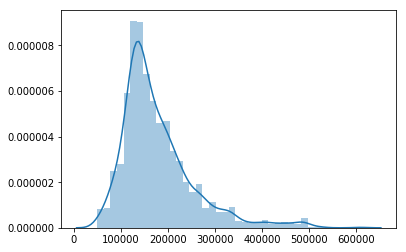

In [95]:
sns.distplot(np.exp(preds))

In [96]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp(preds)})
solution.to_csv("submission_41.csv", index = False)